In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, norm
SX5Edata = pd.read_csv(r'./data/QRM-2022-cw1-data-a.csv',header=0, parse_dates=[0], index_col=0)
#SX5Edata.pop(SX5Edata.columns[0])
SX5Edata['simplereturn'] = SX5Edata['SX5E'].pct_change()
SX5Edata['logreturn'] = np.log(1 + SX5Edata['simplereturn'])
#aux1 = SX5Edata['SX5E']
#logreturns = np.log(aux1[1:] / aux1[:-1])
#SX5Edata['logreturnaux'] = logreturns

# Multiply the return values by 100 so they represent percentage values
SX5Edata['simplereturn']  = SX5Edata['simplereturn']  * 100
SX5Edata['logreturn'] = SX5Edata['logreturn'] * 100


# Q1i

Mu is -> 0.015218810784104798 
Sigma is -> 1.2429050967829507 
Kurtosis is -> 10.126500868169735 
Skewness is -> -0.7774975256432138


,SX5E,simplereturn,logreturn
Date,,,
2012-11-05,2517.669922,NaN,NaN
2012-11-06,2535.939941,0.725672,0.723051
2012-11-07,2479.100098,-2.241372,-2.266872
2012-11-08,2479.129883,0.001201,0.001201
2012-11-09,2479.820068,0.027840,0.027836
...,...,...,...
2013-03-26,2641.120117,-0.308005,-0.308480
2013-03-27,2612.459961,-1.085152,-1.091082
2013-03-28,2624.020020,0.442497,0.441521


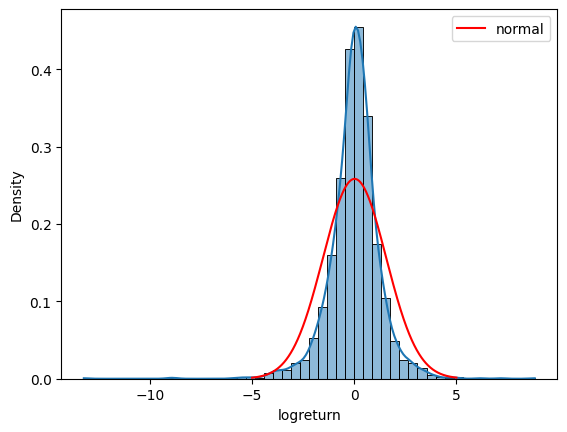

In [5]:

#Calculation of parameters asked
mu = SX5Edata['logreturn'].mean()
sigma = SX5Edata['logreturn'].std()
skw = SX5Edata['logreturn'].skew()
kurt = SX5Edata['logreturn'].kurtosis()

x_values = np.linspace(-5,5,1000)

# Add the plot of N(\mu,\sigma) pdf on top of the seaborn histogram
sns_ax = sns.histplot(data=SX5Edata['logreturn'], bins=50, stat="density", kde=True)
sns_ax.plot(x_values,norm.pdf(x_values,mu ,sigma**2),label="normal", color = 'red')
plt.legend()
print('Mu is ->', mu, '\nSigma is ->', sigma, '\nKurtosis is ->', kurt, '\nSkewness is ->', skw)
SX5Edata.head(100)

# Q1ii

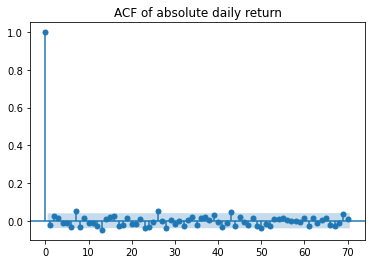

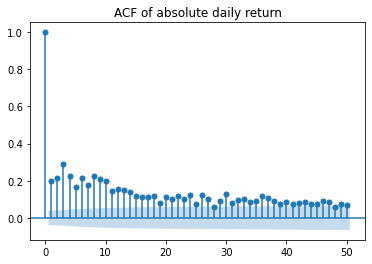

In [2]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(SX5Edata['logreturn'].dropna(), lags=70, title="ACF of absolute daily return")
plt.show()
sm.graphics.tsa.plot_acf(np.abs(SX5Edata['logreturn']).dropna(), lags=50, title="ACF of absolute daily return")
plt.show()

# Q1iii

In [3]:
from arch.univariate import arch_model
garchmodel = arch_model(SX5Edata['logreturn'].dropna())
res = garchmodel.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     37,   Neg. LLF: 3866.417775610774
Iteration:     10,   Func. Count:     63,   Neg. LLF: 3758.8529964211966
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3758.8529956106386
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              logreturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3758.85
Distribution:                  Normal   AIC:                           7525.71
Method:            Maximum Likelihood   BIC:                           7549.02
                                        No. Observations:                 2509
Date:                Mon, Nov 21 2022   Df Residuals:                     2508
Time:        

<class 'arch.univariate.base.ARCHModelResult'>


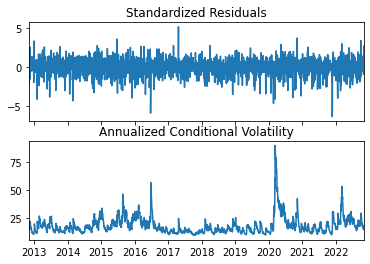

In [4]:
fig = res.plot(annualize="D")
print(type(res))

# Q1v

## Fitting an ARMA(1,1)-GARCH(1,1)-Student-t model

In the final example, we consider an ARMA(1,1)-GARCH(1,1) model 
\begin{align}
X_{t}&=\mu_t+\sigma_t Z_t,\\
\mu_t&=\mu+\phi_1(X_{t-1}-\mu)+\theta_1 (X_{t-1}-\mu_{t-1}),\\
\sigma_t^2&=\alpha_0+\alpha_1 (X_{t-1} - \mu_{t-1})^2 + \beta_1\sigma_{t-1}^2,
\end{align}
where $(Z_t)_t$ follows a normalised Student-t distribution with degree of freedom $\nu$.

The likelihood function $$\ell(\alpha_0,\alpha_1,\beta_1, \mu,\phi_1,\theta_1, \nu;X)=\sum_{t=1}^T \left[-\log \sigma_t + \log f_Z\left(\frac{X_t-\mu_t}{\sigma_t}\right)\right]$$
 is implemented as follow.

In [14]:
from scipy.stats import t # to use the generalised Student-t pdf
from scipy.optimize import minimize #import minimize function from SciPy

def arma11_garch11_t_loglikelihood(alpha0, alpha1, beta1, arma_mu, phi1, theta1, nu, x):

    var = np.zeros_like(x)
    mu = np.zeros_like(x) # for storing the time series of \mu_t

    # We need proxies for sigma_0^2, \mu_0 
    var[0] = np.var(x, ddof=1) # sample variance
    mu[0] = np.mean(x) # sample mean

    # Iteration over the ARMA(1,1)-GARCH(1,1) dynamics
    for i in range(1, len(x)):
        mu[i] = arma_mu + phi1 * (x[i-1] - arma_mu) + theta1 * (x[i-1] - mu[i-1])
        var[i] = alpha0 + alpha1 * (x[i-1] - mu[i-1])**2 + beta1 * var[i-1]

    return np.sum(-0.5*np.log(var[1:]) + np.log(t.pdf((x[1:]-mu[1:])/np.sqrt(var[1:]), nu, 0, np.sqrt((nu-2)/nu))))

objfun_armagarch_t = lambda y : -1 * arma11_garch11_t_loglikelihood(y[0], y[1], y[2], y[3], y[4], y[5], y[6], SX5Edata['logreturn'].dropna())
constraint = lambda y :  1 - y[1] - y[2]

y0 = [1, 0.1, 0.1, 0, 0, 0, 10]
print("Initial objective function value: " + str(objfun_armagarch_t(y0)))

bnds = ((0,np.inf), (0,1), (0,1), (-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (2.01, np.inf))

con = {'type': 'ineq', 'fun': constraint} 

sol = minimize(objfun_armagarch_t,y0,method='SLSQP',bounds=bnds,constraints=con, options={'disp': True})

print("Estimate of alpha0: " + str(sol.x[0]))
print("Estimate of alpha1: " + str(sol.x[1]))
print("Estimate of beta1: " + str(sol.x[2]))
print("Estimate of mu: " + str(sol.x[3]))
print("Estimate of phi1: " + str(sol.x[4]))
print("Estimate of theta1: " + str(sol.x[5]))
print("Estimate of nu: " + str(sol.x[6]))
print("SOlucion->",sol)

Initial objective function value: 3849.3085253764375


C:\Users\Alberto\AppData\Local\Temp/ipykernel_7716/1195891654.py:16: RuntimeWarning: overflow encountered in double_scalars
  var[i] = alpha0 + alpha1 * (x[i-1] - mu[i-1])**2 + beta1 * var[i-1]
C:\Users\Alberto\AppData\Local\Temp/ipykernel_7716/1195891654.py:15: RuntimeWarning: overflow encountered in double_scalars
  mu[i] = arma_mu + phi1 * (x[i-1] - arma_mu) + theta1 * (x[i-1] - mu[i-1])
C:\Users\Alberto\AppData\Local\Temp/ipykernel_7716/1195891654.py:16: RuntimeWarning: invalid value encountered in double_scalars
  var[i] = alpha0 + alpha1 * (x[i-1] - mu[i-1])**2 + beta1 * var[i-1]
C:\Users\Alberto\AppData\Local\Temp/ipykernel_7716/1195891654.py:18: RuntimeWarning: divide by zero encountered in log
  return np.sum(-0.5*np.log(var[1:]) + np.log(t.pdf((x[1:]-mu[1:])/np.sqrt(var[1:]), nu, 0, np.sqrt((nu-2)/nu))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 3651.7804437689865
            Iterations: 31
            Function evaluations: 278
            Gradient evaluations: 30
Estimate of alpha0: 0.041642924601387486
Estimate of alpha1: 0.14003398405521536
Estimate of beta1: 0.8442939417893548
Estimate of mu: 0.07382945520118654
Estimate of phi1: 0.9309412718442186
Estimate of theta1: -0.9533372660065598
Estimate of nu: 4.779050092721349
SOlucion->      fun: 3651.7804437689865
     jac: array([-0.09243774,  0.01199341, -0.04772949, -0.03753662,  0.02896118,
        0.04925537, -0.00177002])
 message: 'Optimization terminated successfully'
    nfev: 278
     nit: 31
    njev: 30
  status: 0
 success: True
       x: array([ 0.04164292,  0.14003398,  0.84429394,  0.07382946,  0.93094127,
       -0.95333727,  4.77905009])
